In [111]:
import pandas as pd
pd.set_option('display.max_columns', 56)
import numpy as np
import seaborn as sns
import xgboost as xgb

import datetime

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Config

In [112]:
# DATA PATHS
TRAIN_PATH = 'data/data_training.csv'
PROV_PATH = 'data/data_provisional.csv'
SAMPLE_PATH = 'data/sample-data.csv'

category = {'low':0, 'medium':1, 'high':2, 'baseline':3, 'channelized':4, 'surprise':5}



### Loading data

In [10]:
def round_time(time_serie):
    time_serie = pd.to_numeric(time_serie)
    time_serie = time_serie.apply(lambda x: datetime.datetime.fromtimestamp(x/1000000))
    time_serie = time_serie.dt.round('1s')
    time_serie = time_serie.apply(lambda x: int(datetime.datetime.timestamp(x)*1000000))
#     time_serie = time_serie.drop_duplicates()
    
    return time_serie

In [4]:
# Load sample data
sample_data = pd.read_csv(SAMPLE_PATH)

# load the first 10^6 rows of train data
train = pd.read_csv(TRAIN_PATH, nrows=1000000)
df = train[train.test_suite == 'Training-Test-038']

In [114]:
train.time.nunique()

717

In [13]:
train.time = round_time(train.time)
df.time = round_time(df.time)

/home/waynn/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [91]:
df[df.time == 1626275616000000].describe()

,time,tlx_score,E4_BVP,E4_GSR,LooxidLink_EEG_A3,LooxidLink_EEG_A4,LooxidLink_EEG_FP1,LooxidLink_EEG_FP2,LooxidLink_EEG_A7,LooxidLink_EEG_A8,Muse_EEG_TP9,Muse_EEG_AF7,Muse_EEG_AF8,Muse_EEG_TP10,Muse_PPG_0,Muse_PPG_1,Muse_PPG_2,Myo_GYR_X,Myo_GYR_Y,Myo_GYR_Z,Myo_EMG_0,Myo_EMG_1,Myo_EMG_2,Myo_EMG_3,Myo_EMG_4,Myo_EMG_5,Myo_EMG_6,Myo_EMG_7,PICARD_fnirs_0,PICARD_fnirs_1,Polar_bpm,Polar_hrv,ViveEye_eyeOpenness_L,ViveEye_pupilDiameter_L,ViveEye_pupilPos_L_X,ViveEye_pupilPos_L_Y,ViveEye_gazeOrigin_L_X,ViveEye_gazeOrigin_L_Y,ViveEye_gazeOrigin_L_Z,ViveEye_gazeDirection_L_X,ViveEye_gazeDirection_L_Y,ViveEye_gazeDirection_L_Z,ViveEye_eyeOpenness_R,ViveEye_pupilDiameter_R,ViveEye_pupilPos_R_X,ViveEye_pupilPos_R_Y,ViveEye_gazeOrigin_R_X,ViveEye_gazeOrigin_R_Y,ViveEye_gazeOrigin_R_Z,ViveEye_gazeDirection_R_X,ViveEye_gazeDirection_R_Y,ViveEye_gazeDirection_R_Z,Zephyr_HR,Zephyr_HRV
count,7.440000e+02,744.0,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,7.440000e+02,7.440000e+02,7.440000e+02,7.440000e+02,7.440000e+02,7.440000e+02,7.440000e+02,744.000000,744.000000,744.000000,744.00000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.000000,744.0,744.000000,744.0,744.0,744.0,744.0,7.440000e+02,744.00000,744.000,744.0,744.0,744.0,744.0,744.0,744.000000,744.000000,744.0000,744.00000,7.440000e+02,744.0,744.0,744.0,744.0,744.0
mean,1.626276e+15,10.0,28.583494,6.185540,-0.004500,-0.055426,0.031800,0.015886,0.076884,0.053501,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-1.821026,-5.303423,1.117974,-0.75000,-1.022849,-0.928763,-0.928763,-0.954301,-0.883065,-0.857527,-0.849462,4482.673387,16129.564516,104.0,13.903151,1.0,-1.0,-1.0,-1.0,3.470630e+01,-8.03111,-33.964,0.0,0.0,0.0,1.0,-1.0,-0.890440,-0.829302,-26.5375,-6.44585,-3.918620e+01,0.0,0.0,0.0,105.0,20.0
std,0.000000e+00,0.0,24.557001,0.009222,0.000019,0.000061,0.000019,0.000022,0.000022,0.000012,1.820213e-12,1.820213e-12,1.820213e-12,1.820213e-12,1.820213e-12,1.820213e-12,1.820213e-12,7.816396,7.601827,11.521382,0.98679,0.812596,0.779295,1.164310,1.040529,1.214995,1.018601,0.963073,294.408012,127.555118,0.0,0.057644,0.0,0.0,0.0,0.0,7.110207e-15,0.00000,0.000,0.0,0.0,0.0,0.0,0.0,0.348547,0.542989,0.0000,0.00000,7.110207e-15,0.0,0.0,0.0,0.0,0.0
min,1.626276e+15,10.0,-7.277534,6.177330,-0.004538,-0.055521,0.031758,0.015848,0.076843,0.053478,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-10.247100,-15.124500,-14.877000,-3.00000,-2.000000,-3.000000,-3.000000,-3.000000,-4.000000,-3.000000,-4.000000,3880.000000,15664.000000,104.0,13.861800,1.0,-1.0,-1.0,-1.0,3.470630e+01,-8.03111,-33.964,0.0,0.0,0.0,1.0,-1.0,-1.000000,-1.000000,-26.5375,-6.44585,-3.918620e+01,0.0,0.0,0.0,105.0,20.0
25%,1.626276e+15,10.0,2.134171,6.177330,-0.004513,-0.055505,0.031787,0.015869,0.076865,0.053492,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-7.997070,-10.218250,-10.002000,-1.00000,-2.000000,-1.000000,-2.000000,-2.000000,-2.000000,-2.000000,-1.000000,4235.000000,16021.000000,104.0,13.861800,1.0,-1.0,-1.0,-1.0,3.470630e+01,-8.03111,-33.964,0.0,0.0,0.0,1.0,-1.0,-1.000000,-1.000000,-26.5375,-6.44585,-3.918620e+01,0.0,0.0,0.0,105.0,20.0
50%,1.626276e+15,10.0,28.981330,6.177330,-0.004495,-0.055398,0.031796,0.015877,0.076881,0.053499,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-5.747070,-7.874510,4.873050,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4432.000000,16153.000000,104.0,13.861800,1.0,-1.0,-1.0,-1.0,3.470630e+01,-8.03111,-33.964,0.0,0.0,0.0,1.0,-1.0,-1.000000,-1.000000,-26.5375,-6.44585,-3.918620e+01,0.0,0.0,0.0,105.0,20.0
75%,1.626276e+15,10.0,50.178760,6.196538,-0.004483,-0.055388,0.031816,0.015906,0.076906,0.053512,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03

In [92]:
df[df.time == 1626275989000000].describe()

,time,tlx_score,E4_BVP,E4_GSR,LooxidLink_EEG_A3,LooxidLink_EEG_A4,LooxidLink_EEG_FP1,LooxidLink_EEG_FP2,LooxidLink_EEG_A7,LooxidLink_EEG_A8,Muse_EEG_TP9,Muse_EEG_AF7,Muse_EEG_AF8,Muse_EEG_TP10,Muse_PPG_0,Muse_PPG_1,Muse_PPG_2,Myo_GYR_X,Myo_GYR_Y,Myo_GYR_Z,Myo_EMG_0,Myo_EMG_1,Myo_EMG_2,Myo_EMG_3,Myo_EMG_4,Myo_EMG_5,Myo_EMG_6,Myo_EMG_7,PICARD_fnirs_0,PICARD_fnirs_1,Polar_bpm,Polar_hrv,ViveEye_eyeOpenness_L,ViveEye_pupilDiameter_L,ViveEye_pupilPos_L_X,ViveEye_pupilPos_L_Y,ViveEye_gazeOrigin_L_X,ViveEye_gazeOrigin_L_Y,ViveEye_gazeOrigin_L_Z,ViveEye_gazeDirection_L_X,ViveEye_gazeDirection_L_Y,ViveEye_gazeDirection_L_Z,ViveEye_eyeOpenness_R,ViveEye_pupilDiameter_R,ViveEye_pupilPos_R_X,ViveEye_pupilPos_R_Y,ViveEye_gazeOrigin_R_X,ViveEye_gazeOrigin_R_Y,ViveEye_gazeOrigin_R_Z,ViveEye_gazeDirection_R_X,ViveEye_gazeDirection_R_Y,ViveEye_gazeDirection_R_Z,Zephyr_HR,Zephyr_HRV
count,9.920000e+02,992.0,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,9.920000e+02,9.920000e+02,9.920000e+02,9.920000e+02,9.920000e+02,9.920000e+02,9.920000e+02,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000,992.000000
mean,1.626276e+15,31.0,-79.114181,-6.938221,0.016130,-0.027359,0.053757,0.054362,0.091240,0.056497,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-14.572257,-1.119783,-20.614564,-10.956552,-10.955544,-10.884980,-10.922278,-11.048286,-11.856754,-10.590625,-10.888004,4554.549496,17309.544456,93.814617,8.521185,-9.983859,-8.083648,-10.261156,-9.992411,24.375904,-17.648678,-44.557131,-10.017201,-9.983787,-9.514376,-9.917057,-10.021168,-10.822069,-10.676895,-36.885561,-18.986845,-43.487662,-10.022914,-10.033693,-9.926108,91.816633,7.901310
std,0.000000e+00,0.0,322.481016,317.597380,0.000375,0.000151,0.000261,0.000405,0.000073,0.000013,1.819907e-12,1.819907e-12,1.819907e-12,1.819907e-12,1.819907e-12,1.819907e-12,1.819907e-12,317.359708,317.790798,317.195320,317.472554,317.472896,317.474896,317.485439,317.563431,317.593677,317.778458,317.479009,560.219536,891.669141,320.799146,318.088344,317.500222,317.571253,317.492176,317.501310,318.592243,317.257632,316.404891,317.499160,317.500231,317.515504,317.502344,317.506097,317.473974,317.479164,316.645228,317.214110,316.435563,317.499006,317.498649,317.502230,320.735646,318.068643
min,1.626276e+15,31.0,-9999.900000,-9999.900000,0.004350,-0.032118,0.045571,0.041656,0.089017,0.056237,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000
25%,1.626276e+15,31.0,-128.409200,2.957414,0.016119,-0.027358,0.053748,0.054348,0.091227,0.056489,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-9.999900e+03,-5.624020,7.251950,-11.878400,-2.000000,-2.000000,-2.000000,-3.000000,-6.000000,-9.000000,-5.000000,-2.000000,4308.000000,17214.000000,104.000000,18.620500,0.022186,-1.000000,-1.000000,-1.000000,34.451900,-7.328400,-35.279800,0.000000,0.000000,0.000000,0.105519,-1.000000,-1.000000,-1.000000,-26.825600,-8.964550,-33.425400,0.000000,0.000000,0.000000,102.000000,18.000000
50%,1.626276e+15,31.0,-25.834850,2.957414,0.016145,-0.027353,0.053758,0.054

In [67]:
df.iloc[117790:117793]

,time,test_suite,induced_state,tlx_score,E4_BVP,E4_GSR,LooxidLink_EEG_A3,LooxidLink_EEG_A4,LooxidLink_EEG_FP1,LooxidLink_EEG_FP2,LooxidLink_EEG_A7,LooxidLink_EEG_A8,Muse_EEG_TP9,Muse_EEG_AF7,Muse_EEG_AF8,Muse_EEG_TP10,Muse_PPG_0,Muse_PPG_1,Muse_PPG_2,Myo_GYR_X,Myo_GYR_Y,Myo_GYR_Z,Myo_EMG_0,Myo_EMG_1,Myo_EMG_2,Myo_EMG_3,Myo_EMG_4,Myo_EMG_5,Myo_EMG_6,Myo_EMG_7,PICARD_fnirs_0,PICARD_fnirs_1,Polar_bpm,Polar_hrv,ViveEye_eyeOpenness_L,ViveEye_pupilDiameter_L,ViveEye_pupilPos_L_X,ViveEye_pupilPos_L_Y,ViveEye_gazeOrigin_L_X,ViveEye_gazeOrigin_L_Y,ViveEye_gazeOrigin_L_Z,ViveEye_gazeDirection_L_X,ViveEye_gazeDirection_L_Y,ViveEye_gazeDirection_L_Z,ViveEye_eyeOpenness_R,ViveEye_pupilDiameter_R,ViveEye_pupilPos_R_X,ViveEye_pupilPos_R_Y,ViveEye_gazeOrigin_R_X,ViveEye_gazeOrigin_R_Y,ViveEye_gazeOrigin_R_Z,ViveEye_gazeDirection_R_X,ViveEye_gazeDirection_R_Y,ViveEye_gazeDirection_R_Z,Zephyr_HR,Zephyr_HRV
117790,1626275616000000,Training-Test-038,baseline,10,20.528830,6.185013,-0.004482,-0.055402,0.031834,0.015929,0.076924,0.053493,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-10.24710,-3.87451,-12.0020,-1.0,-1.0,0.0,-3.0,-1.0,1.0,-2.0,0.0,4432.0,16006.0,104.0,13.9834,1.0,-1.0,-1.0,-1.0,34.7063,-8.03111,-33.964,0.0,0.0,0.0,1.0,-1.0,-1.0,-1.0,-26.5375,-6.44585,-39.1862,0.0,0.0,0.0,105.0,20.0
117791,1626275989000000,Training-Test-038,channelized,31,-9999.900000,-9999.900000,0.016088,-0.027357,0.053731,0.054318,0.091209,0.056478,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.90000,-9999.90000,-9999.9000,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9000,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9000,-9999.90000,-9999.900,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9000,-9999.90000,-9999.9000,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9
117792,1626275989000000,Training-Test-038,channelized,31,-9.915283,4.389510,0.004350,-0.032118,0.045571,0.041656,0.089017,0.056237,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-7.99902,13.87700,14.6216,-2.0,0.0,0.0,-3.0,-1.0,2.0,-2.0,1.0,5238.0,17216.0,104.0,18.6205,0.0,-1.0,-1.0,-1.0,34.7256,-9.03139,-32.261,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-26.8066,-8.79105,-35.8389,0.0,0.0,0.0,102.0,18.0


In [56]:
df.time.value_counts().sort_index().iloc[gap_index]

1626275616000000     744
1626276083000000     485
1626276618000000     678
1626276963000000     775
1626277322000000     264
1626277960000000    1344
1626278025000000     903
1626278125000000     325
1626278194000000     274
1626278259000000    1257
1626278339000000    1230
1626278444000000    1229
1626278512000000     887
1626278610000000    1254
1626279022000000    1048
Name: time, dtype: int64

In [110]:
df.groupby(['test_suite'])['induced_state'].value_counts().max()

260786

In [103]:
df.induced_state.value_counts().index

Index(['high', 'medium', 'low', 'channelized', 'baseline'], dtype='object')

In [86]:
datetime.datetime.fromtimestamp( 1626279021 )  

datetime.datetime(2021, 7, 15, 0, 10, 21)

In [88]:
df['datetime'] = df.time.apply(lambda x: datetime.datetime.fromtimestamp(x/1000000)  )

<ipython-input-88-fcb6b1a8aee7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = df.time.apply(lambda x: datetime.datetime.fromtimestamp(x/1000000)  )


In [89]:
df['datetime']

0        2021-07-14 23:12:20
1        2021-07-14 23:12:20
2        2021-07-14 23:12:20
3        2021-07-14 23:12:20
4        2021-07-14 23:12:20
                 ...        
990209   2021-07-15 00:13:04
990210   2021-07-15 00:13:04
990211   2021-07-15 00:13:04
990212   2021-07-15 00:13:04
990213   2021-07-15 00:13:04
Name: datetime, Length: 990214, dtype: datetime64[ns]

In [45]:
gap_index = np.where(np.diff(df.time.value_counts().sort_index().index.tolist())/1000000 > 1)

(array([ 76, 171, 279, 372, 443, 451, 455, 464, 472, 482, 493, 509, 513,
        557, 594]),)

In [39]:
dict(zip(, df.time.value_counts().sort_index().values.tolist()))

{1.0: 1558,
 373.0: 744,
 428.0: 485,
 253.0: 678,
 289.0: 775,
 631.0: 264,
 62.0: 325,
 92.0: 903,
 56.0: 274,
 70.0: 1257,
 90.0: 1230,
 65.0: 1229,
 55.0: 887,
 376.0: 1254,
 107.0: 1048}

In [8]:
train[train.test_suite == 'Training-Test-067']

,time,test_suite,induced_state,tlx_score,E4_BVP,E4_GSR,LooxidLink_EEG_A3,LooxidLink_EEG_A4,LooxidLink_EEG_FP1,LooxidLink_EEG_FP2,LooxidLink_EEG_A7,LooxidLink_EEG_A8,Muse_EEG_TP9,Muse_EEG_AF7,Muse_EEG_AF8,Muse_EEG_TP10,Muse_PPG_0,Muse_PPG_1,Muse_PPG_2,Myo_GYR_X,Myo_GYR_Y,Myo_GYR_Z,Myo_EMG_0,Myo_EMG_1,Myo_EMG_2,Myo_EMG_3,Myo_EMG_4,Myo_EMG_5,Myo_EMG_6,Myo_EMG_7,PICARD_fnirs_0,PICARD_fnirs_1,Polar_bpm,Polar_hrv,ViveEye_eyeOpenness_L,ViveEye_pupilDiameter_L,ViveEye_pupilPos_L_X,ViveEye_pupilPos_L_Y,ViveEye_gazeOrigin_L_X,ViveEye_gazeOrigin_L_Y,ViveEye_gazeOrigin_L_Z,ViveEye_gazeDirection_L_X,ViveEye_gazeDirection_L_Y,ViveEye_gazeDirection_L_Z,ViveEye_eyeOpenness_R,ViveEye_pupilDiameter_R,ViveEye_pupilPos_R_X,ViveEye_pupilPos_R_Y,ViveEye_gazeOrigin_R_X,ViveEye_gazeOrigin_R_Y,ViveEye_gazeOrigin_R_Z,ViveEye_gazeDirection_R_X,ViveEye_gazeDirection_R_Y,ViveEye_gazeDirection_R_Z,Zephyr_HR,Zephyr_HRV
990214,1626369899641012,Training-Test-067,low,10,-9999.90000,-9999.90000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.90000,-9999.90000,-9999.90000,-3.0,0.0,0.0,-1.0,-2.0,1.0,0.0,-2.0,-9999.9,-9999.9,-9999.9,-9999.9000,-9999.900000,-9999.90000,-9999.900000,-9999.900000,-9999.9000,-9999.90000,-9999.9000,-9999.900000,-9999.900000,-9999.900000,-9999.900000,-9999.9000,-9999.90000,-9999.900000,-9999.9000,-9999.90000,-9999.9000,-9999.900000,-9999.900000,-9999.90000,-9999.9,-9999.9
990215,1626369899641643,Training-Test-067,low,10,23.64038,0.67391,0.027146,0.007711,0.069756,0.068262,0.103762,0.059912,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-12.87260,6.12646,2.99756,-1.0,-1.0,1.0,0.0,-2.0,0.0,-1.0,-1.0,3927.0,13591.0,93.0,23.7651,0.829984,2.87138,0.490789,0.696983,33.1148,-2.67308,-35.7064,0.024597,0.249405,0.968079,0.319784,2.9696,0.41583,0.798305,-28.6517,-6.53415,-32.5962,-0.065582,0.298203,0.95224,90.0,37.0
990216,1626369899648411,Training-Test-067,low,10,23.64038,0.67391,0.027146,0.007711,0.069756,0.068262,0.103762,0.059912,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,6.87158,14.99900,-6.74854,-1.0,-1.0,1.0,0.0,-2.0,0.0,-1.0,-1.0,3927.0,13591.0,93.0,23.7651,0.829984,2.87138,0.490789,0.696983,33.1148,-2.67308,-35.7064,0.024597,0.249405,0.968079,0.319784,2.9696,0.41583,0.798305,-28.6517,-6.53415,-32.5962,-0.065582,0.298203,0.95224,90.0,37.0
990217,1626369899663619,Training-Test-067,low,10,23.64038,0.67391,0.027146,0.007711,0.069756,0.068262,0.103762,0.059912,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,6.87158,14.99900,-6.74854,0.0,0.0,-2.0,-2.0,0.0,1.0,0.0,0.0,3927.0,13591.0,93.0,23.7651,0.829984,2.87138,0.490789,0.696983,33.1148,-2.67308,-35.7064,0.024597,0.249405,0.968079,0.319784,2.9696,0.41583,0.798305,-28.6517,-6.53415,-32.5962,-0.065582,0.298203,0.95224,90.0,37.0
990218,1626369899664210,Training-Test-067,low,10,23.64038,0.67391,0.027146,0.007711,0.069756,0.068262,0.103762,0.059912,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,6.87158,14.99900,-6.74854,-1.0,-2.0,-2.0,1.0,0.0,1.0,-1.0,-2.0,3927.0,13591.0,93.0,23.7651,0.829984,2.87138,0.490789,0.696983,33.1148,-2.67308,-35.7064,0.024597,0.249405,0.968079,0.319784,2.9696,0.41583,0.798305,-28.6517,-6.53415,-32.5962,-0.065582,0.298203,0.95224,90.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1626369964974328,Training-Test-067,low,10,23.64038,0.67391,0.027146,0.007711,0.069756,0.068262,0.103762,0.059912,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,1.37158,-12.75100,-10.62350,-2.0,2.0,-1.0,-1.0,-1.0,-1.0,-2.0,-1.0,3927.0,13591.0,93.0,23.7651,0.829984,2.87138,0.490789,0.696983,33.1148,-2.67308,-35.7064,0.024597,0.249405,0.968079,0.319784,2.9696,0.41583,0.798305,-28.6517,-6.53415,-32.5962,-0.065582,0.298203,0.95224,90.0,37.0
999996,1626369964995578,Training-T

In [9]:
df.tail()

,time,test_suite,induced_state,tlx_score,E4_BVP,E4_GSR,LooxidLink_EEG_A3,LooxidLink_EEG_A4,LooxidLink_EEG_FP1,LooxidLink_EEG_FP2,LooxidLink_EEG_A7,LooxidLink_EEG_A8,Muse_EEG_TP9,Muse_EEG_AF7,Muse_EEG_AF8,Muse_EEG_TP10,Muse_PPG_0,Muse_PPG_1,Muse_PPG_2,Myo_GYR_X,Myo_GYR_Y,Myo_GYR_Z,Myo_EMG_0,Myo_EMG_1,Myo_EMG_2,Myo_EMG_3,Myo_EMG_4,Myo_EMG_5,Myo_EMG_6,Myo_EMG_7,PICARD_fnirs_0,PICARD_fnirs_1,Polar_bpm,Polar_hrv,ViveEye_eyeOpenness_L,ViveEye_pupilDiameter_L,ViveEye_pupilPos_L_X,ViveEye_pupilPos_L_Y,ViveEye_gazeOrigin_L_X,ViveEye_gazeOrigin_L_Y,ViveEye_gazeOrigin_L_Z,ViveEye_gazeDirection_L_X,ViveEye_gazeDirection_L_Y,ViveEye_gazeDirection_L_Z,ViveEye_eyeOpenness_R,ViveEye_pupilDiameter_R,ViveEye_pupilPos_R_X,ViveEye_pupilPos_R_Y,ViveEye_gazeOrigin_R_X,ViveEye_gazeOrigin_R_Y,ViveEye_gazeOrigin_R_Z,ViveEye_gazeDirection_R_X,ViveEye_gazeDirection_R_Y,ViveEye_gazeDirection_R_Z,Zephyr_HR,Zephyr_HRV
990209,1626279183568473,Training-Test-038,high,70,22.4081,0.641896,-0.019464,-0.008654,0.084967,0.085433,0.119666,0.075088,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,2.62793,6.75146,-1.87744,4.0,0.0,-2.0,0.0,-2.0,3.0,1.0,11.0,3628.0,14002.0,89.0,157.099,0.605704,3.06752,0.380178,0.872706,34.659,-6.61168,-33.1909,0.291473,-0.018143,0.95639,0.0,-1.0,-1.0,-1.0,-27.2626,-7.98331,-32.4984,0.0,0.0,0.0,87.0,36.0
990210,1626279183569511,Training-Test-038,high,70,22.4081,0.641896,-0.019464,-0.008654,0.084967,0.085433,0.119666,0.075088,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,2.62793,6.75146,-1.87744,4.0,0.0,-2.0,0.0,-2.0,3.0,1.0,11.0,3610.0,13473.0,89.0,157.099,0.605704,3.06752,0.380178,0.872706,34.659,-6.61168,-33.1909,0.291473,-0.018143,0.95639,0.0,-1.0,-1.0,-1.0,-27.2626,-7.98331,-32.4984,0.0,0.0,0.0,87.0,36.0
990211,1626279183570472,Training-Test-038,high,70,22.4081,0.641896,-0.019454,-0.008654,0.084966,0.085433,0.119673,0.075090,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,2.62793,6.75146,-1.87744,4.0,0.0,-2.0,0.0,-2.0,3.0,1.0,11.0,3610.0,13473.0,89.0,157.099,0.605704,3.06752,0.380178,0.872706,34.659,-6.61168,-33.1909,0.291473,-0.018143,0.95639,0.0,-1.0,-1.0,-1.0,-27.2626,-7.98331,-32.4984,0.0,0.0,0.0,87.0,36.0
990212,1626279183572471,Training-Test-038,high,70,22.4081,0.641896,-0.019453,-0.008657,0.084968,0.085434,0.119677,0.075088,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,2.62793,6.75146,-1.87744,4.0,0.0,-2.0,0.0,-2.0,3.0,1.0,11.0,3610.0,13473.0,89.0,157.099,0.605704,3.06752,0.380178,0.872706,34.659,-6.61168,-33.1909,0.291473,-0.018143,0.95639,0.0,-1.0,-1.0,-1.0,-27.2626,-7.98331,-32.4984,0.0,0.0,0.0,87.0,36.0
990213,1626279183573593,Training-Test-038,high,70,22.4081,0.641896,-0.019453,-0.008657,0.084968,0.085434,0.119677,0.075088,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,-9999.9,2.62793,6.75146,-1.87744,4.0,0.0,-2.0,0.0,-2.0,3.0,1.0,11.0,3610.0,13473.0,89.0,157.099,0.605704,3.06752,0.380178,0.872706,34.659,-6.61168,-33.1909,0.291473,-0.018143,0.95639,0.0,-1.0,-1.0,-1.0,-27.2626,-7.98331,-32.4984,0.0,0.0,0.0,87.0,36.0


## Preprocessing

In [4]:
# replace  'induced_state'
df["induced_state"] = df["induced_state"].replace(category)
df.set_index('time', inplace=True)

# drop cols 
drop_cols = ['test_suite', 'induced_state'] #, 'tlx_score']

# split data into Train & Test
X = df.loc[:, [ c not in drop_cols for c in df.columns]]
Y = df['induced_state']

<ipython-input-4-18ba22b64753>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["induced_state"] = df["induced_state"].replace(category)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

xg_train = xgb.DMatrix(X_train, label=y_train)
xg_test = xgb.DMatrix( X_test, label=y_test)

## Training

In [13]:
param = {
    'booster': 'gbtree',
    'objective': 'multi:softmax',  # 多分类的问题
    'num_class': 6,               # 类别数，与 multisoftmax 并用
    'gamma': 0.1,                  # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
    'max_depth': 12,               # 构建树的深度，越大越容易过拟合
    'lambda': 2,                   # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    'subsample': 0.7,              # 随机采样训练样本
    'colsample_bytree': 0.7,       # 生成树时进行的列采样
    'min_child_weight': 3,
#     'silent': 1,                   # 设置成1则没有运行信息输出，最好是设置为0.
    'eta': 0.007,                  # 如同学习率
    'seed': 1000,
#     'nthread': 4,                  # cpu 线程数
}

In [14]:
# xgboost.train(params,dtrain,num_boost_round=10,evals=(),obj=None,feval=None,maximize=False,early_stopping_rounds=None,
# evals_result=None,verbose_eval=True,learning_rates=None,xgb_model=None)

In [39]:
watchlist = [ (xg_train,'train'), (xg_test, 'test') ]
num_round = 10
bst = xgb.train(param, xg_train, num_round, watchlist, early_stopping_rounds=10 );

[22:43:21] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:43:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-mlogloss:1.77189	test-mlogloss:1.77110
[1]	train-mlogloss:1.75001	test-mlogloss:1.75004
[2]	train-mlogloss:1.72847	test-mlogloss:1.72956
[3]	train-mlogloss:1.70968	test-mlogloss:1.71091
[4]	train-mlogloss:1.68842	test-mlogloss:1.69073
[5]	train-mlogloss:1.67518	test-mlogloss:1.67206
[6]	train-mlogloss:1.65568	test-mlogloss:1.65392
[7]	train-mlogloss:1.63524	test-mlogloss:1.63582

In [40]:
pred = bst.predict( xg_test );

In [41]:
print (f'predicting, classification error={sum(pred!=y_test)/len(y_test)}')

predicting, classification error=2.52470423089935e-05


In [42]:
sum(pred!=y_test)

5

### Evaluation

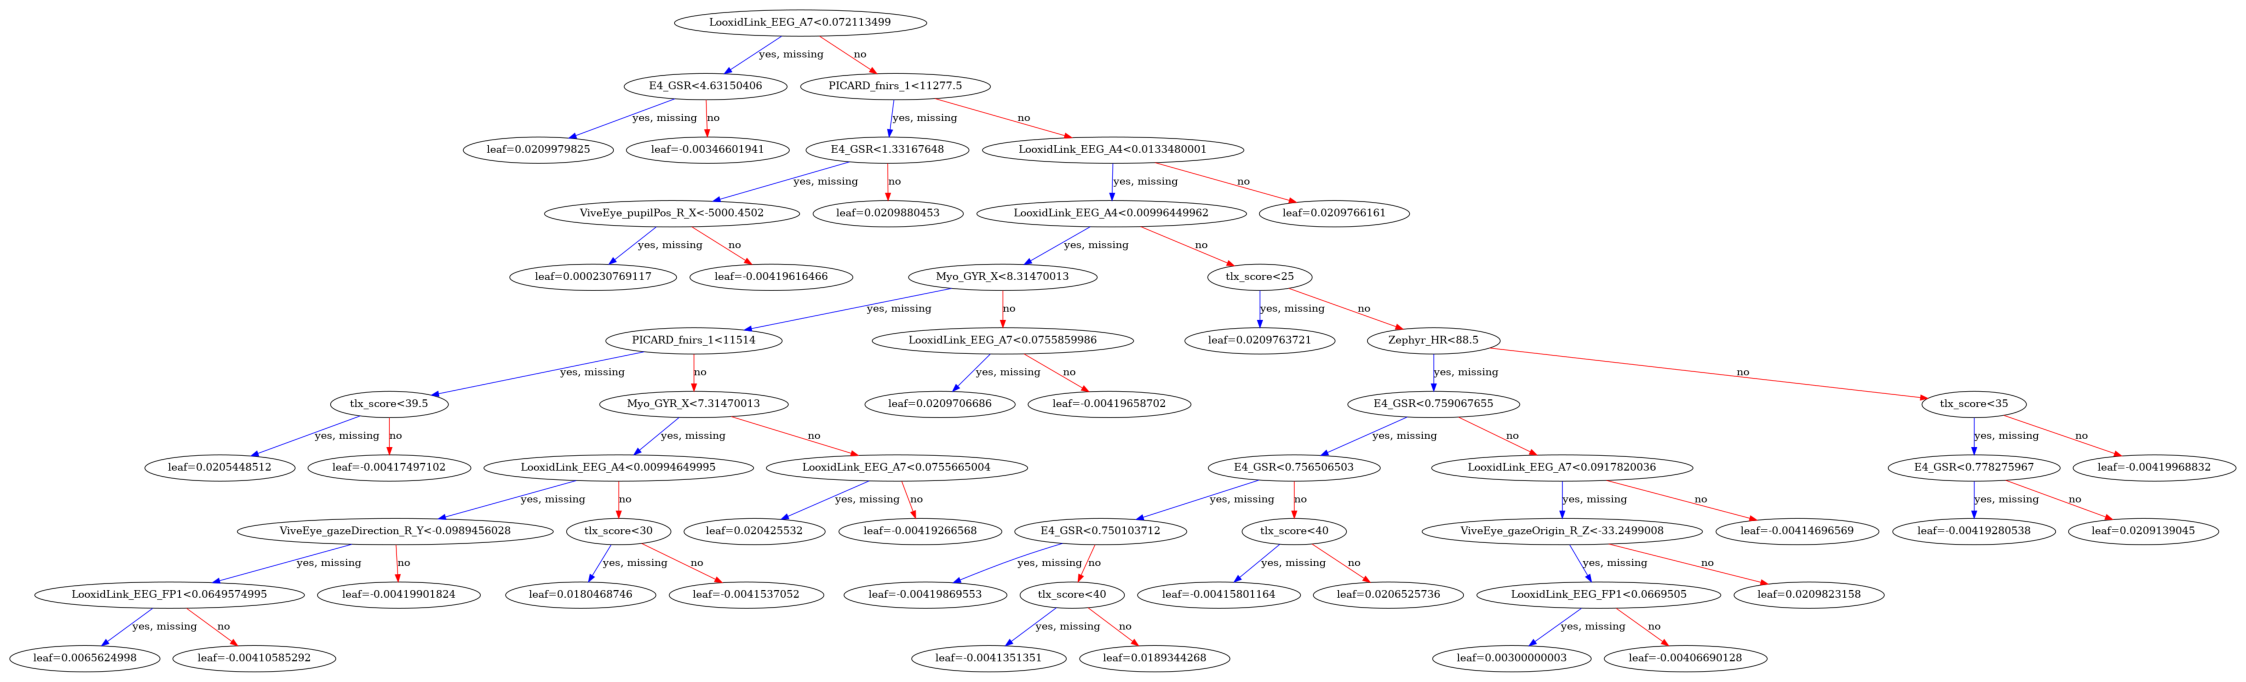

In [46]:
# plot rendered tree
xgb.plot_tree(bst,num_trees=0)
plt.rcParams['figure.figsize'] = [40, 40]
plt.show()

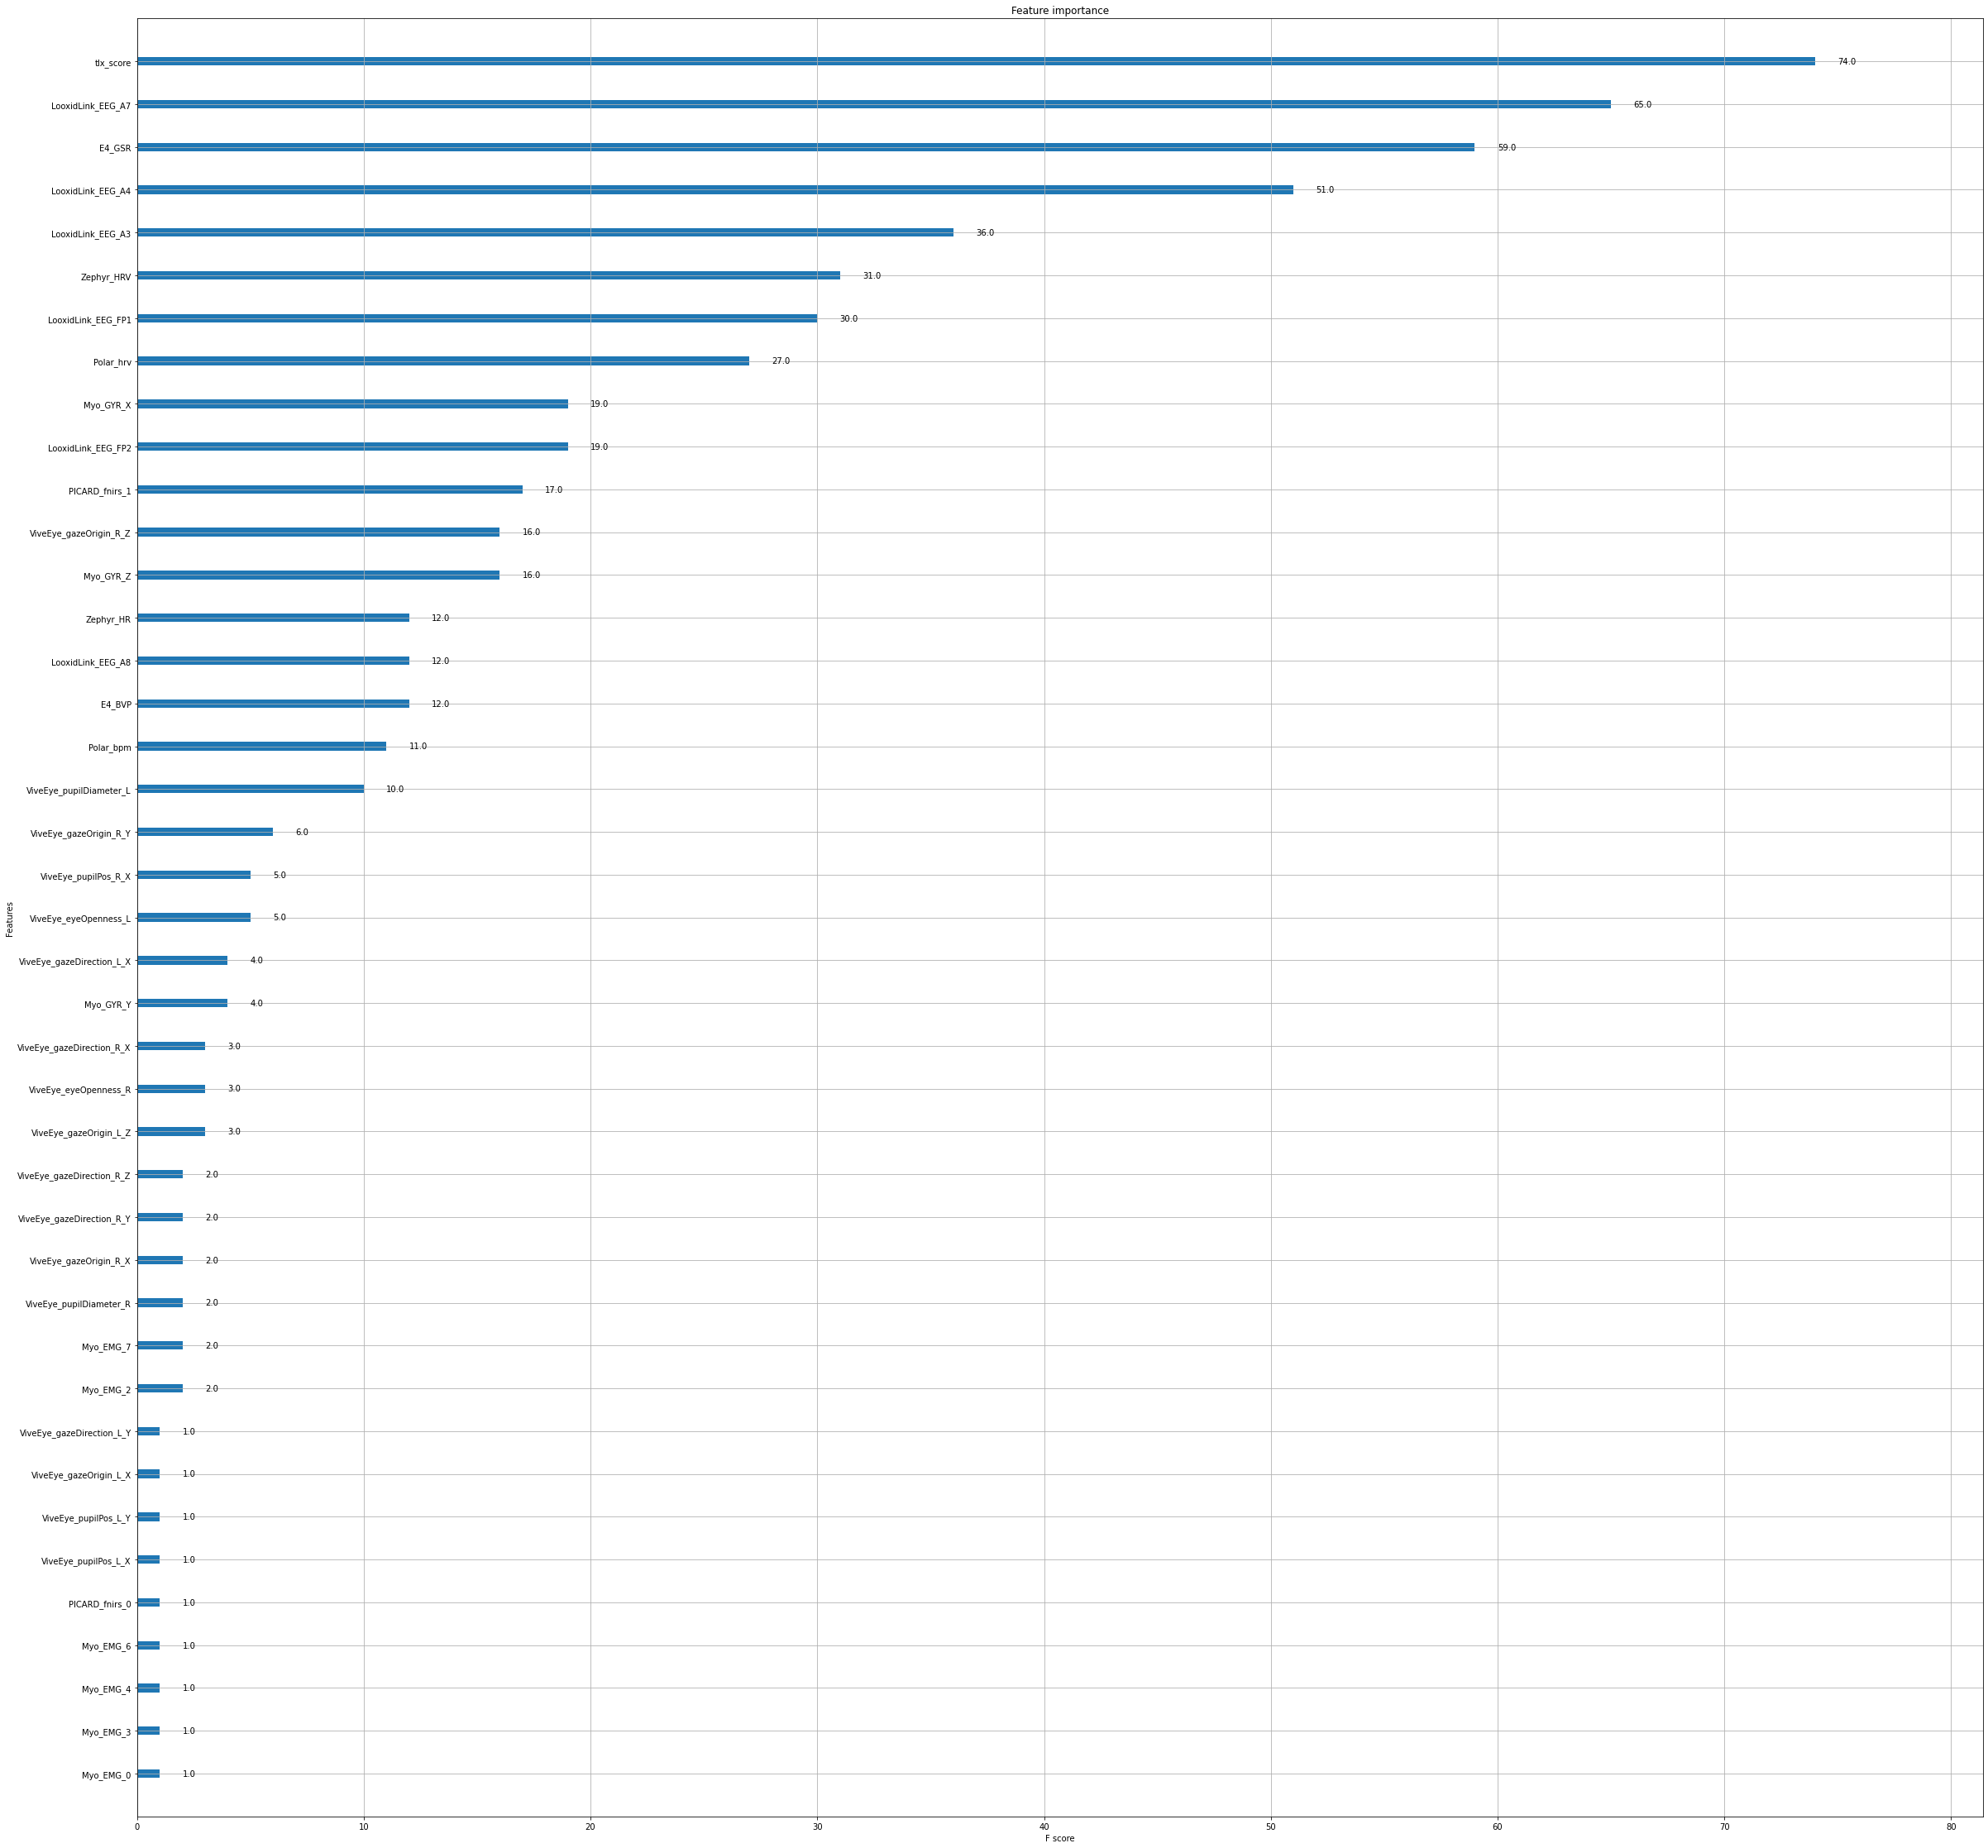

In [47]:
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [12, 12]
plt.show()